<a href="https://colab.research.google.com/github/anujgupta82/NLP_Bootcamp/blob/V_2_0/module2/CBOW/CBOW_barebones_wiki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Tensor board projection 
- Visualizing loss and network on tensorboard
- Comments 

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p drive
!google-drive-ocamlfuse drive

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131183 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.11-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.11-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.11-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redir

In [2]:
!pip install mpld3==0.3
!pip install --user "git+https://github.com/javadba/mpld3@display_fix"

     |████████████████████████████████| 798kB 2.0MB/s 
  Created wheel for mpld3: filename=mpld3-0.3-cp36-none-any.whl size=116679 sha256=0ef3f2c40322e4f07942fdf107fd21bc0fda7284d0a158c6aa0d465a1d99a7ca
  Stored in directory: /root/.cache/pip/wheels/c0/47/fb/8a64f89aecfe0059830479308ad42d62e898a3e3cefdf6ba28
Successfully built mpld3
  Cloning https://github.com/javadba/mpld3 (to revision display_fix) to /tmp/pip-req-build-5dvlgndk
  Running command git clone -q https://github.com/javadba/mpld3 /tmp/pip-req-build-5dvlgndk
  Running command git checkout -b display_fix --track origin/display_fix
  Switched to a new branch 'display_fix'
  Branch 'display_fix' set up to track remote branch 'display_fix' from 'origin'.
  Running command git submodule update --init --recursive -q
  Created wheel for mpld3: filename=mpld3-0.3.1.dev1-cp36-none-any.whl size=116957 sha256=9a389dae72d159ecadf5df89276431c1d5fd0cfec1f8f648b6bc3cc1e20d89f3
  Stored in directory: /tmp/pip-ephem-wheel-cache-v4a1g9k2/wh

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import mpld3
mpld3.enable_notebook()

In [0]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

In [0]:
import sys
import numpy as np 
import random
import math
import tensorflow as tf
import matplotlib.pyplot as plt 

sys.path.append("/content/drive//GoogleDrive_Utils/")

In [0]:
from readWikiData import get_wikipedia_data

##### Get representation

In [0]:
sentences, word2idx, idx2word, _ = get_wikipedia_data(n_files=10, n_vocab=1000, by_paragraph=True)

In [0]:
def get_wiki_data_cbow(sentences, word2idx, window_size=5):
    training_data = []
    vocab_size = len(word2idx)
    for sentence in sentences:
        if len(sentence) < window_size * 2 + 1:
            continue
        for i in range(len(sentence)):
            left_context = sentence[max(i-window_size, 0): i]
            right_context = sentence[i+1:window_size + i + 1]
            centre = sentence[i]
            
            if len(left_context + right_context) < (2*window_size):
                len_left = len(left_context)
                len_right = len(right_context)
                
                if len_left < len_right:
                    right_context = sentence[i+1 : window_size + i + 1 + (len_right - len_left)]
                else:
                    left_context = sentence[max(i-window_size - (len_left - len_right), 0): i]
            
            temp = left_context + right_context
            
            if len(temp) < window_size * 2:
                print (sentence)
                print (left_context)
                print (right_context)
                print (centre)
                break 
            
            training_data.append((tuple(temp), centre))
            
            
    print (training_data[:10])
    training_data = list(set(training_data))
    idx2word = {v:k for k, v in word2idx.items()}
    return len(word2idx), training_data, word2idx, idx2word

In [10]:
vocab_size, training_data, word2idx, idx2word = get_wiki_data_cbow(sentences, word2idx)

[((8, 7, 227, 949, 12, 1000, 1000, 1000, 161, 15), 1000), ((1000, 7, 227, 949, 12, 1000, 1000, 1000, 161, 15), 8), ((1000, 8, 227, 949, 12, 1000, 1000, 1000, 161, 15), 7), ((1000, 8, 7, 949, 12, 1000, 1000, 1000, 161, 15), 227), ((1000, 8, 7, 227, 12, 1000, 1000, 1000, 161, 15), 949), ((1000, 8, 7, 227, 949, 1000, 1000, 1000, 161, 15), 12), ((8, 7, 227, 949, 12, 1000, 1000, 161, 15, 1000), 1000), ((7, 227, 949, 12, 1000, 1000, 161, 15, 1000, 1000), 1000), ((227, 949, 12, 1000, 1000, 161, 15, 1000, 1000, 55), 1000), ((949, 12, 1000, 1000, 1000, 15, 1000, 1000, 55, 16), 161)]


In [11]:
len(training_data)

11880092

In [12]:
training_data[:10]

[((1000, 1000, 5, 1000, 1000, 7, 1000, 202, 500, 4), 1000),
 ((5, 1000, 62, 20, 1000, 424, 79, 15, 5, 1000), 6),
 ((1000, 1000, 17, 456, 18, 6, 1000, 5, 2, 1000), 876),
 ((92, 1000, 1000, 1000, 429, 1000, 1000, 14, 864, 1000), 16),
 ((1000, 2, 1000, 1000, 1000, 6, 1000, 11, 113, 1000), 1000),
 ((147, 6, 1000, 190, 238, 245, 5, 2, 1000, 4), 1000),
 ((1000, 17, 2, 240, 2, 1000, 10, 577, 6, 1000), 1000),
 ((6, 1000, 1000, 1000, 4, 159, 1000, 3, 617, 9), 7),
 ((1000, 61, 130, 47, 668, 9, 268, 1000, 678, 17), 18),
 ((32, 1000, 1000, 16, 45, 1000, 3, 1000, 4, 1000), 9)]

##### Get batches

In [0]:
bucket_list = []

def getNextBatchCbow(bi_grams_, window_size=5, batch_size=10000):
    global bucket_list
    docs_ids_to_select = list(set(bi_grams_) - set(bucket_list))
    
    if len(docs_ids_to_select) < batch_size:
        bucket_list = []
        docs_ids_to_select = bi_grams_
        
    # Initialize two variables 
    train_X = np.ndarray(shape=(batch_size, window_size*2), dtype=np.int32)
    train_label = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    # Get a random set of docs 
    random_docs = random.sample(docs_ids_to_select, batch_size)
    bucket_list += random_docs
    
    
    index = 0 
    
    # Iterate threw all the docs 
    for item in random_docs:
        train_X[index] = item[0]
        train_label[index] = item[1]  
        index += 1
            
    return train_X, train_label

In [0]:
#getNextBatchCbow(training_data, 2)

##### Let's design the graph 

In [0]:
def init_weight(Mi, Mo):
    shape_sum = float(Mi + Mo) 
    return np.random.uniform(-np.sqrt(6/shape_sum),np.sqrt(6/shape_sum), [Mi, Mo])

In [0]:
embedding_size_w = 100
vocab_size = len(word2idx)
n_neg_samples = 20
learning_rate = 10e-5
epochs = 2
batch_size=10000
mu = 0.99
window_size = 5

In [0]:
# Define placeholders for training 
train_X = tf.placeholder(tf.int32, shape=[batch_size, None])
train_label = tf.placeholder(tf.int32, shape=[batch_size, 1])

In [0]:
# Define matrix for doc_embedding and word_embedding 
W1 = tf.Variable(init_weight(vocab_size, embedding_size_w), name="W1", dtype=tf.float32)

In [0]:
# Define weights for the output unit 
W2 = tf.Variable(init_weight(vocab_size, embedding_size_w), name="W2", dtype=tf.float32)
biases = tf.Variable(tf.zeros(vocab_size))

In [20]:
print(train_X.get_shape(), train_label.get_shape(), W1.get_shape(), W2.get_shape())

(10000, ?) (10000, 1) (1001, 100) (1001, 100)


In [0]:
embed = []

# generating a vector of size embedding_size_d
embed_w = tf.zeros([1, embedding_size_w], dtype=tf.float32)

# add all the word vecs in window_size
for j in range(window_size*2):
    embed_w += tf.nn.embedding_lookup(W1, train_X[:, j])
#embed.append(embed_w)

#embed = tf.concat(1, embed)/(window_size*2)
embed = embed_w/(window_size*2)

In [22]:
print(embed.get_shape())

(10000, 100)


In [0]:
loss = tf.nn.sampled_softmax_loss(weights=W2, \
                                  biases=biases, \
                                  labels=train_label, \
                                  inputs=embed, \
                                  num_sampled=n_neg_samples, \
                                  num_classes=vocab_size)

In [0]:
loss = tf.reduce_mean(loss)

In [0]:
#optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=mu).minimize(loss)
#optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss)


global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.01
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           1000, 0.96, staircase=True)
# Passing global_step to minimize() will increment it at each step.
optimizer = (
    tf.train.MomentumOptimizer(learning_rate, momentum=mu).minimize(loss, global_step=global_step)
)


In [26]:
saver = tf.train.Saver()

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    average_loss = 0
    
    for step in range(epochs):
        epoch_error = 0.0
        temp_X , temp_labels = getNextBatchCbow(window_size=5, bi_grams_=training_data)
        
        
        
        
        feed_dict = {train_X : temp_X, train_label : temp_labels}
        
        op, l = sess.run([optimizer, loss], 
                                    feed_dict=feed_dict)
        
        epoch_error += l
                
        if step % 100 == 0:
            print ("Error at epoch : ", step, " = ", epoch_error)
            
    save_path = saver.save(sess, "./models/model_cbow_model.ckpt")
    print("Model saved in file: %s" % save_path)

Error at epoch :  0  =  3.3201348781585693
Model saved in file: ./models/model_cbow_model.ckpt


##### Embeddings 

In [27]:
W1_embedding = None
W2_embedding = None 

with tf.Session() as sess:
    saver = tf.train.Saver()
    # Restore variables from disk.
    saver.restore(sess, "./models/model_cbow_model.ckpt")
    print("Model restored.")
    
    # Normalize word2vec 
    W1_embedding = W1.eval()
    
    # Normalize word2vec 
    W2_embedding = W2.eval()

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./models/model_cbow_model.ckpt
Model restored.


In [28]:
W1_embedding.shape

(1001, 100)

In [29]:
W2_embedding.shape

(1001, 100)

In [0]:
word2vec = np.mean([W1_embedding, W2_embedding], axis=0)

In [31]:
word2vec.shape

(1001, 100)

##### Projection of embeddings using t-SNE 

In [0]:
idx2word = {v:k for k, v in word2idx.items()}

In [0]:
from sklearn.manifold import TSNE
model = TSNE()
Z = model.fit_transform(word2vec) 

TypeError: ignored

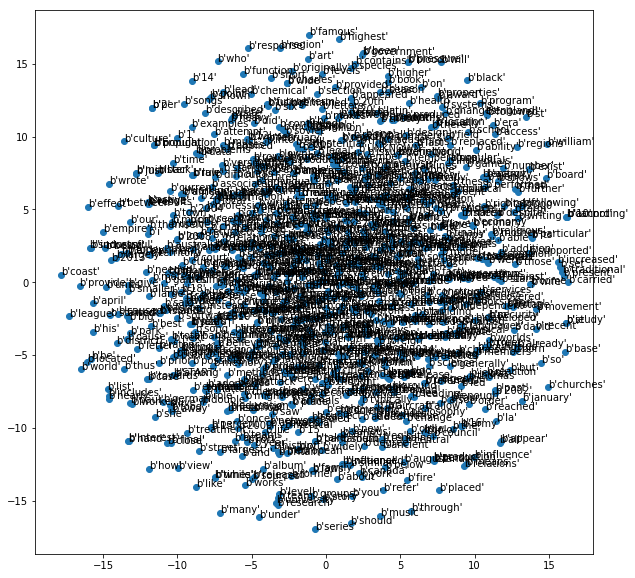

In [34]:
plt.scatter(Z[:,0], Z[:,1])
for i in range(len(idx2word)):
    try:
        plt.annotate(s=idx2word[i].encode("utf8"), xy=(Z[i,0], Z[i,1]))
    except:
        print ("bad string:", idx2word[i])
plt.show()